In [2]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.stats import regress
from nltools.external import glover_hrf

課題設定：
- 脳のどこの領域が顔を処理するのに関わっているかを特定する
- 顔の画像を見せた時に、脳のどの領域が活発化するかを調べる
  - trial : 1つの顔の画像を見せる実験
- 5 trialsでどのようになるかみてみる
- はじめに、facesを、タイムポイントの時系列ベクトルとしてして定義する
  - 全単位時間：200
  - 全トライアル回数：5

![faces](../images/glm/faces.png)

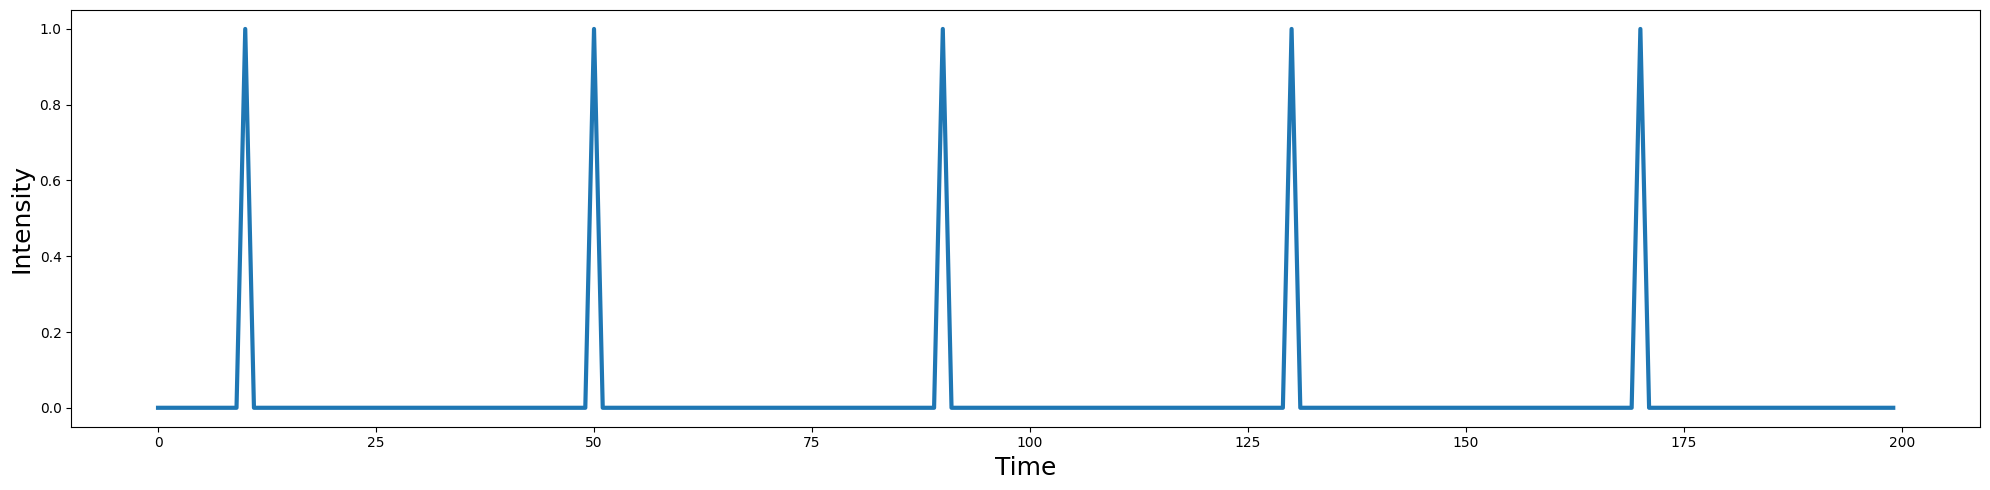

In [3]:
n_tr = 200 # 時系列のボリューム数
n_trial = 5 # 試行数
face = np.zeros(n_tr) # 時系列データとしてfacesを初期化

# 10 時間ボリューム以降、trialがあるところでfacesを1にする
face[np.arange(10, n_tr, int(n_tr/n_trial))] = 1

def plot_timeseries(data, labels=None, linewidth=3):
    '''Plot a timeseries
    
    Args:
        data: (np.ndarray) signal varying over time, where each column is a different signal.
        labels: (list) labels which need to correspond to the number of columns.
        linewidth: (int) thickness of line
    '''
    
    plt.figure(figsize=(20,5))
    plt.plot(data, linewidth=linewidth)
    plt.ylabel('Intensity', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    plt.tight_layout()
    
    # ラベルがあるかをみる
    if labels is not None:
        # さらに、ラベルの数とデータの列数が一致しているかをみる
        if len(labels) != data.shape[1]:
            # 一致していない場合はエラーを出す
            raise ValueError('Need to have the same number of labels as columns in data.')
        plt.legend(labels, fontsize=18)
    
plot_timeseries(face)


- でも画像刺激だったら、何にでも反応するのでは？
  - 顔特有に反応している領域を見つけるには、もう一つ比較する条件をつける必要がある。
    - 例：輝度もカラーも同じ、でもフーリエ変換→位相だけランダムにする（phase_scarmbled）→逆フーリエ変換、をした画像を見せる
    - 視覚の低次元の性質・プロパティーは統制できるかもしれない

![phase](../images/glm/phase_scrambled.png)

- 一方で、高次元の視覚的性質はどうか？
  - 顔とはオブジェクトであり、これでも統制したい。全てのオブジェクトに反応するのではなく、顔だけに反応する領域を見つけたい。
  - 

![objects](../images/glm/objects.png)

- 2つの条件は、異なるタイプのビジュアルコントロール（統制）をする。
- ここではシンプルに、視覚の低次元の性質も統制しつつ、オブジェクトでもあるものを見せて統制したい。
  - 統制をコントラストと言ったりもする。
  - fMRIはrelativeなので、contrastのような引き算型の解析は適している。

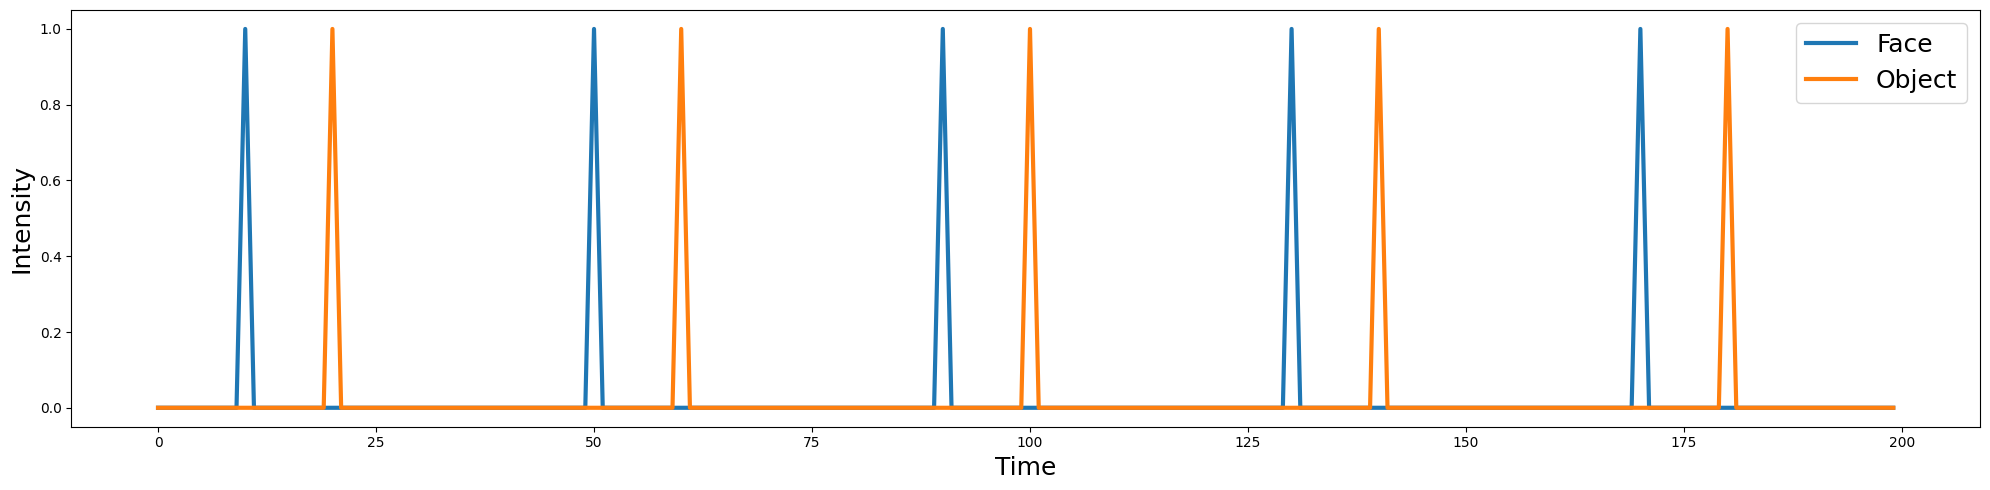

In [4]:
# FaceとObjectを見せるときの時系列データを作成

n_tr = 200
n_trial = 5
face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = 1
obj = np.zeros(n_tr)
obj[np.arange(20, n_tr, int(n_tr/n_trial))] = 1
voxel = np.vstack([face,obj]).T

plot_timeseries(voxel, labels=['Face', 'Object'])

シミュレーションとして、顔を見ている時は、２倍の反応があるとしてみる

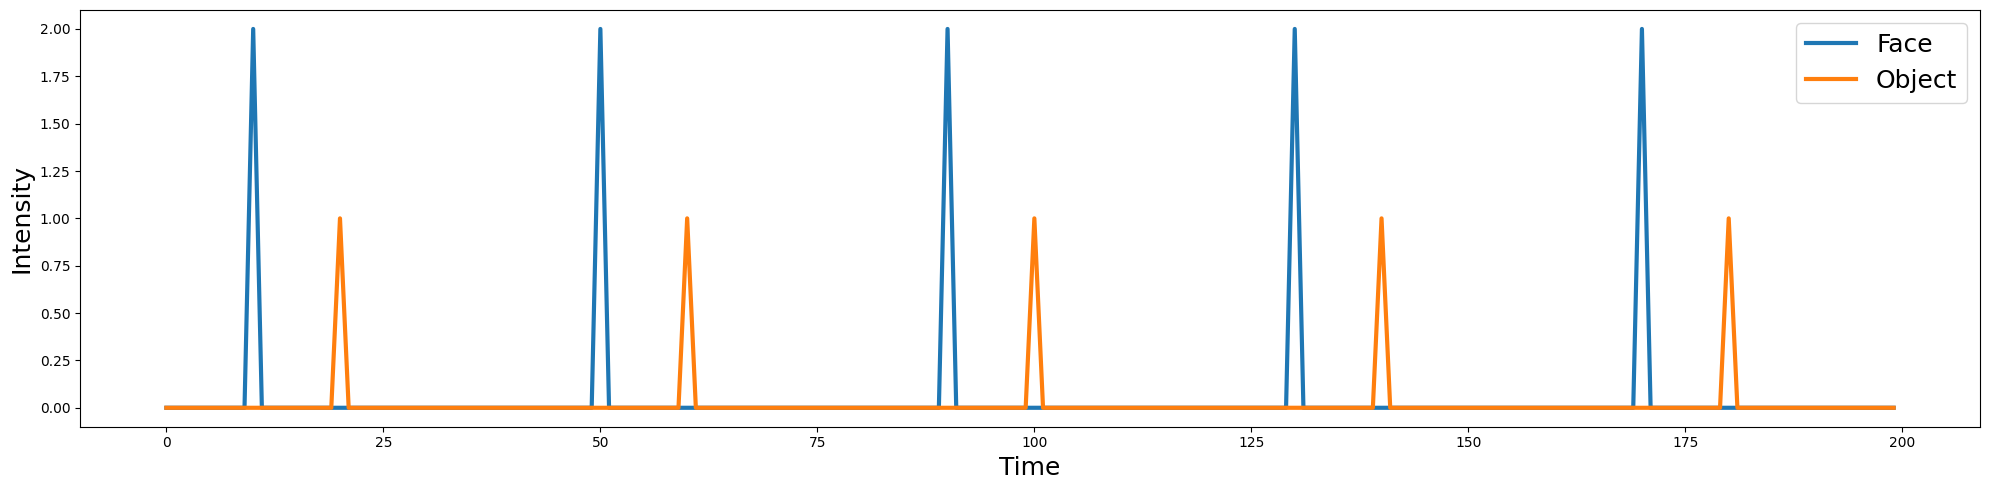

In [5]:
n_tr = 200
n_trial = 5
face_intensity = 2
object_intensity = 1

face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = face_intensity
obj = np.zeros(n_tr)
obj[np.arange(20, n_tr, int(n_tr/n_trial))] = object_intensity
voxel = np.vstack([face,obj]).T

plot_timeseries(voxel, labels=['Face', 'Object'])

刺激から血液動態への変換には時間がかかる。→ 時間変化のモデルとして、double-gamma HRFを使い、上のと畳み込みしてみる

まずは、畳み込み前のもの。

Text(0.5, 0, 'Time')

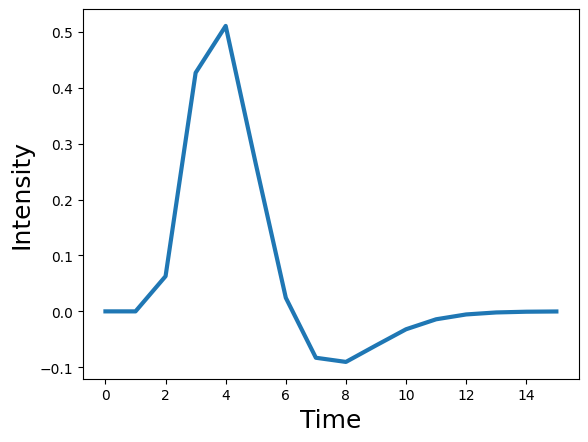

In [6]:
tr = 2
hrf = glover_hrf(tr, oversampling=1)
plt.plot(hrf, linewidth=3)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

畳み込みをしてみると、

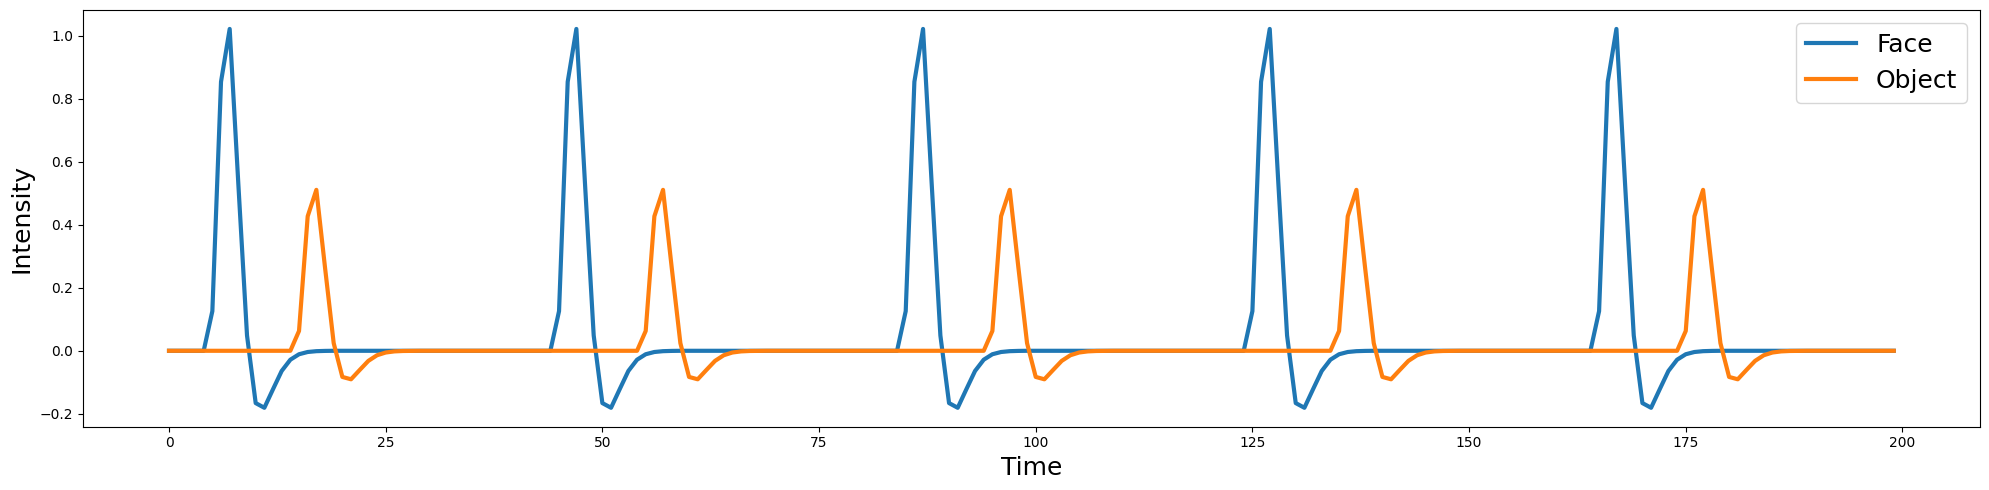

In [8]:
face_conv = np.convolve(face, hrf, mode='same')
obj_conv = np.convolve(obj, hrf, mode='same')
voxel_conv = np.vstack([face_conv, obj_conv]).T

plot_timeseries(voxel_conv, labels=['Face', 'Object'])

リアルデータに近づけるためにノイズを加えて、

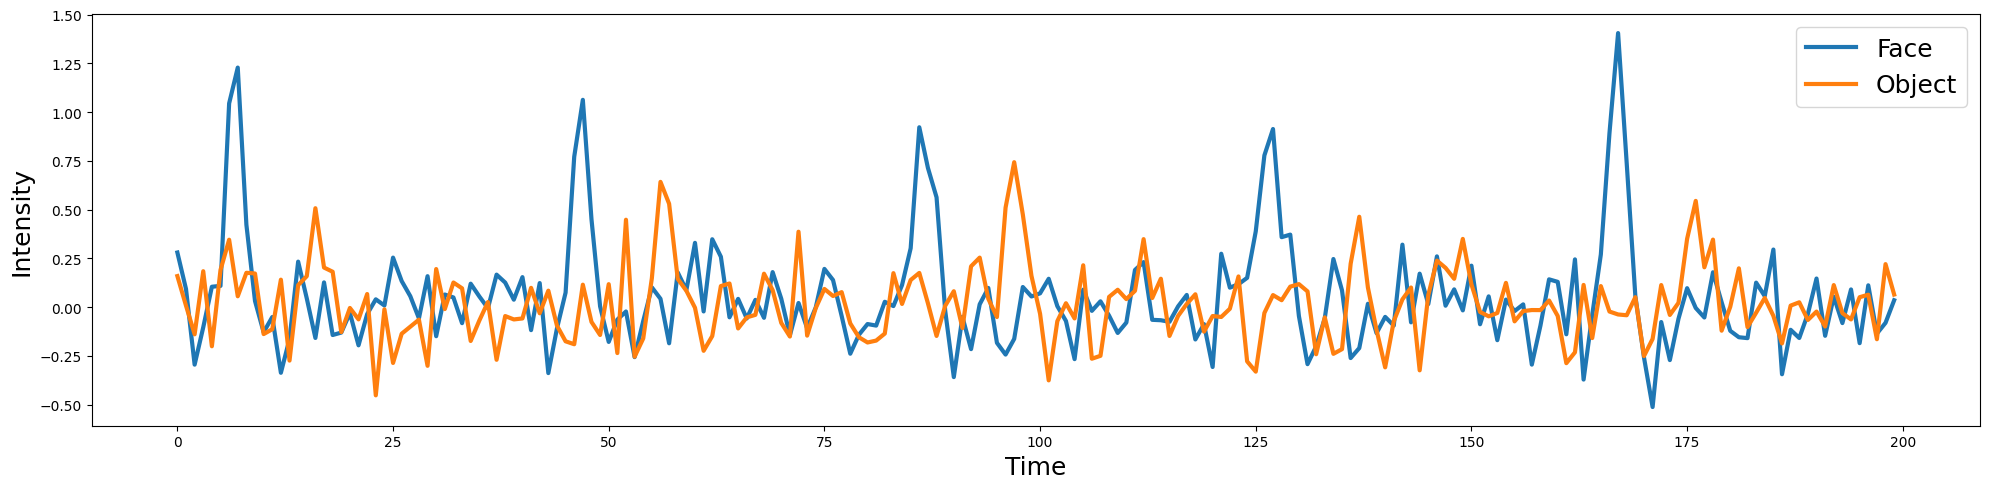

In [9]:
sigma = 0.15
epsilon = sigma*np.random.randn(n_tr, 2)
voxel_conv_noise = voxel_conv + epsilon

plot_timeseries(voxel_conv_noise, labels=['Face', 'Object'])

実際には、顔とオブジェクトどちらの信号かはわからない（時間的に見れば分かるものではある）から、一つの系列にしてリアルっぽくすると、

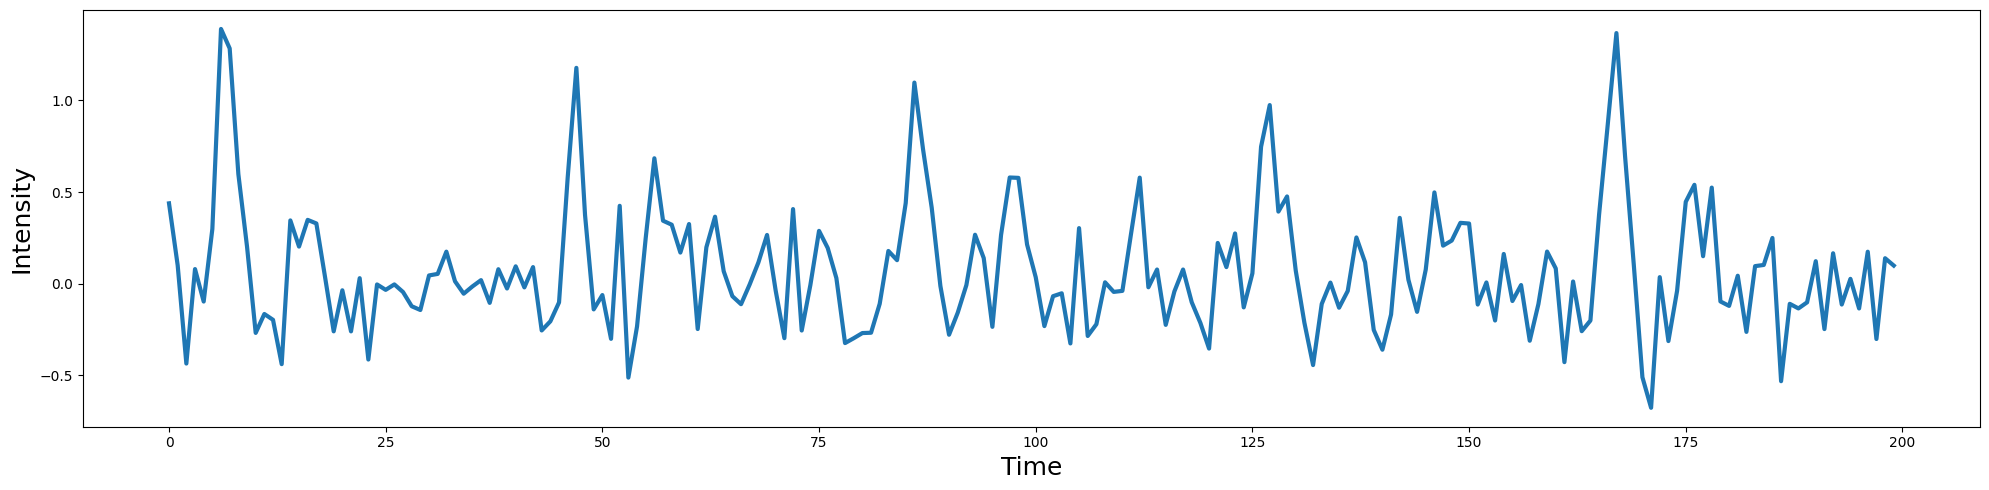

In [10]:
Y = voxel_conv_noise.sum(axis=1)

plot_timeseries(Y)

# 計画行列の作成

- ボクセルの反応を予測してみる。
  - X : HRFと刺激の畳み込み
  - Y : さっき作ったノイズまみれのデータ
- 時系列情報は無視する。

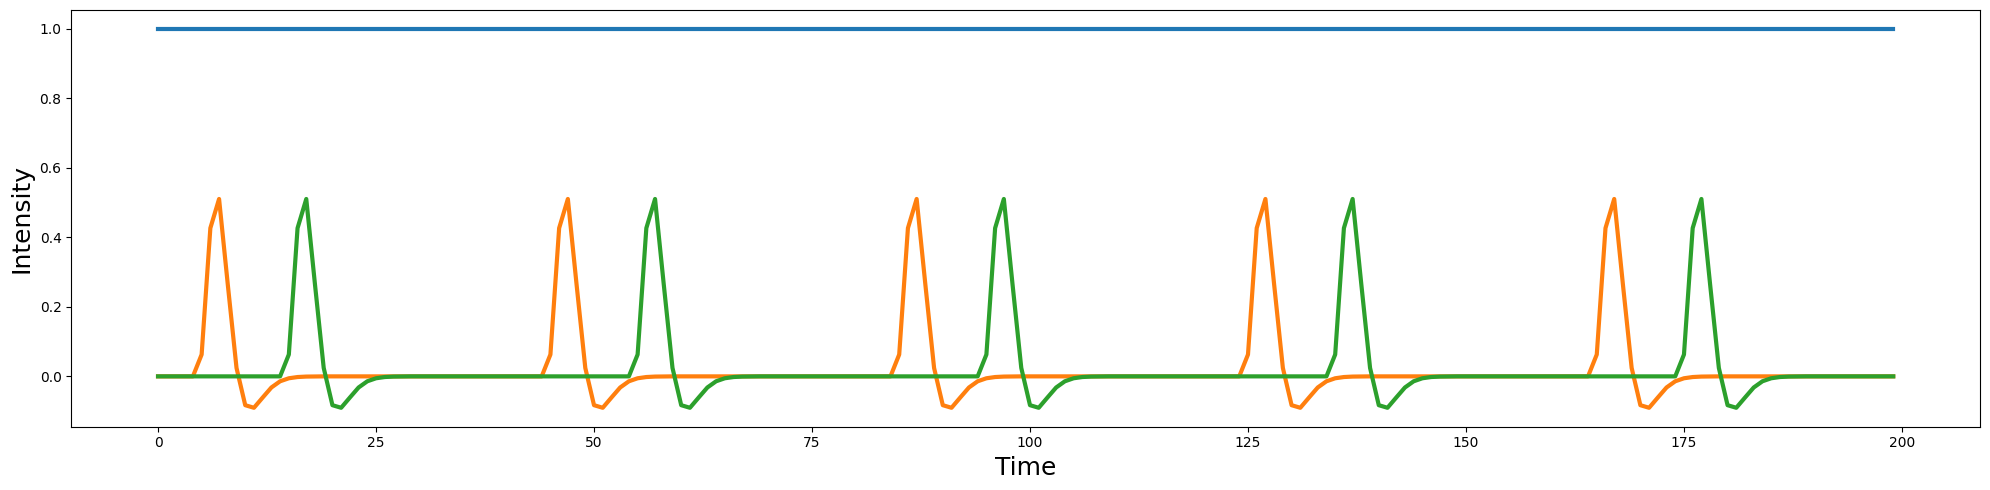

In [12]:
# Design Matrix
n_tr = 200
n_trial = 5
face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = 1
obj = np.zeros(n_tr)
obj[np.arange(20, n_tr, int(n_tr/n_trial))] = 1
intercept = np.ones(n_tr)
X = np.vstack([intercept, np.convolve(face, hrf, mode='same'), np.convolve(obj, hrf, mode='same')]).T

plot_timeseries(X)

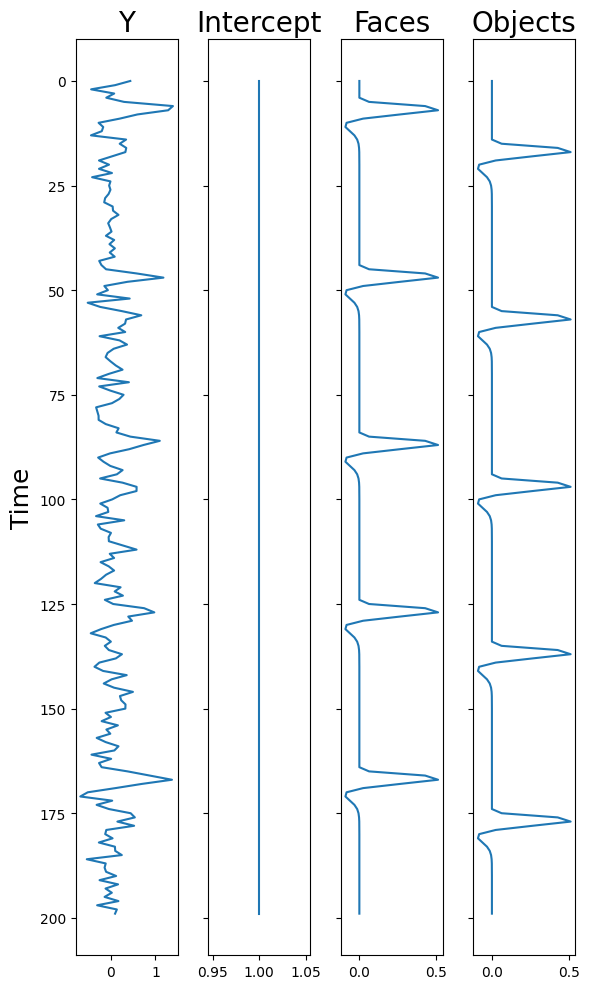

In [13]:
f, a = plt.subplots(ncols=4, figsize=(6, 10), sharey=True)
a[0].plot(np.expand_dims(Y, axis=1), range(len(Y)))
a[1].plot(X[:,0], range(len(Y)))
a[2].plot(X[:,1], range(len(Y)))
a[3].plot(X[:,2], range(len(Y)))
a[0].set_ylabel('Time', fontsize=18)
a[0].set_title('Y', fontsize=20)
a[1].set_title('Intercept', fontsize=20)
a[2].set_title('Faces', fontsize=20)
a[3].set_title('Objects', fontsize=20)
plt.gca().invert_yaxis()
plt.tight_layout()

# GLMで回帰問題をとき、パラメータの推定をする

beta Faces - beta Objects: 1.4


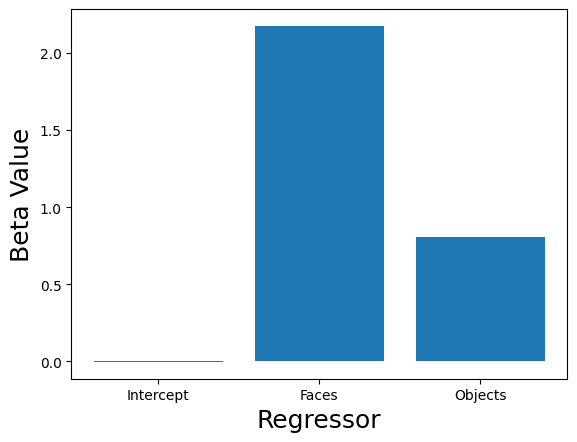

In [14]:
def ols_estimator(X, Y):
    return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)

beta = ols_estimator(X, Y)

plt.bar(['Intercept','Faces', 'Objects'], beta)
plt.xlabel('Regressor', fontsize=18)
plt.ylabel('Beta Value', fontsize=18)

print(f'beta Faces - beta Objects: {beta[1]-beta[2]:.2}')

Text(0.5, 1.0, 'Residual')

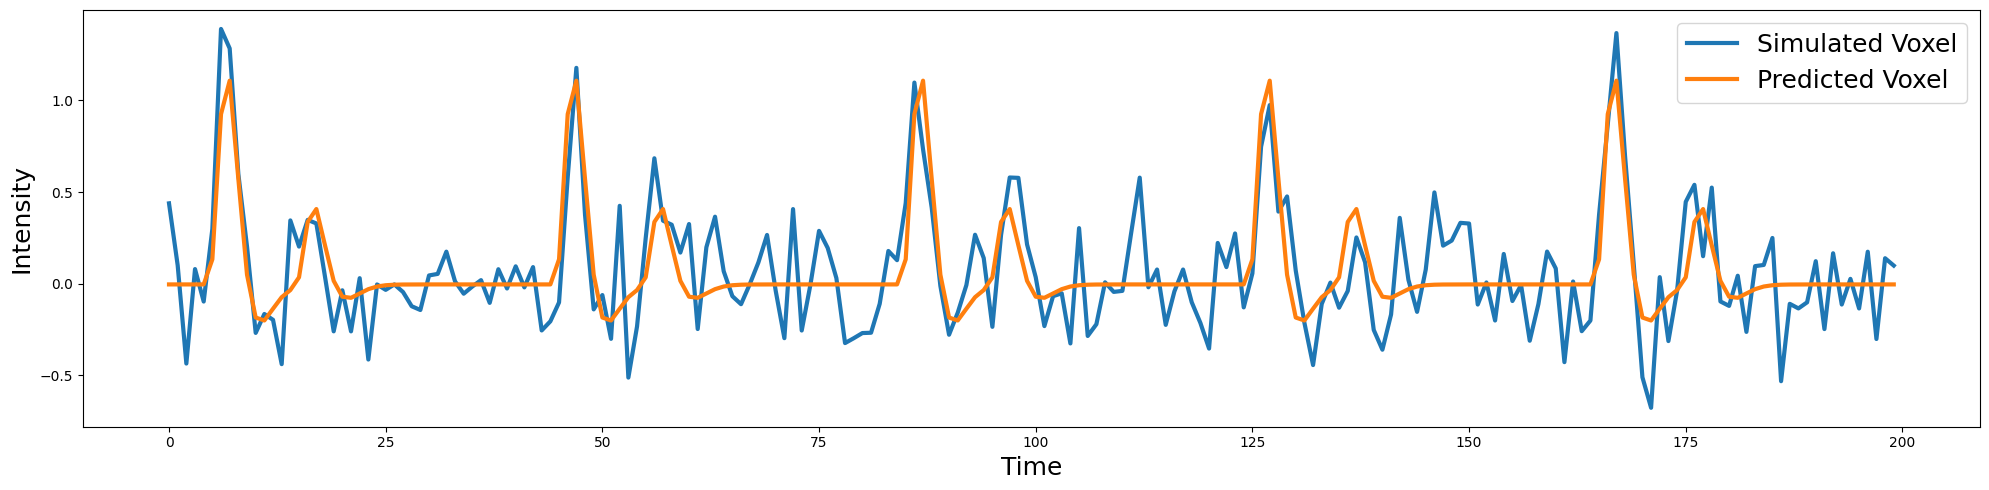

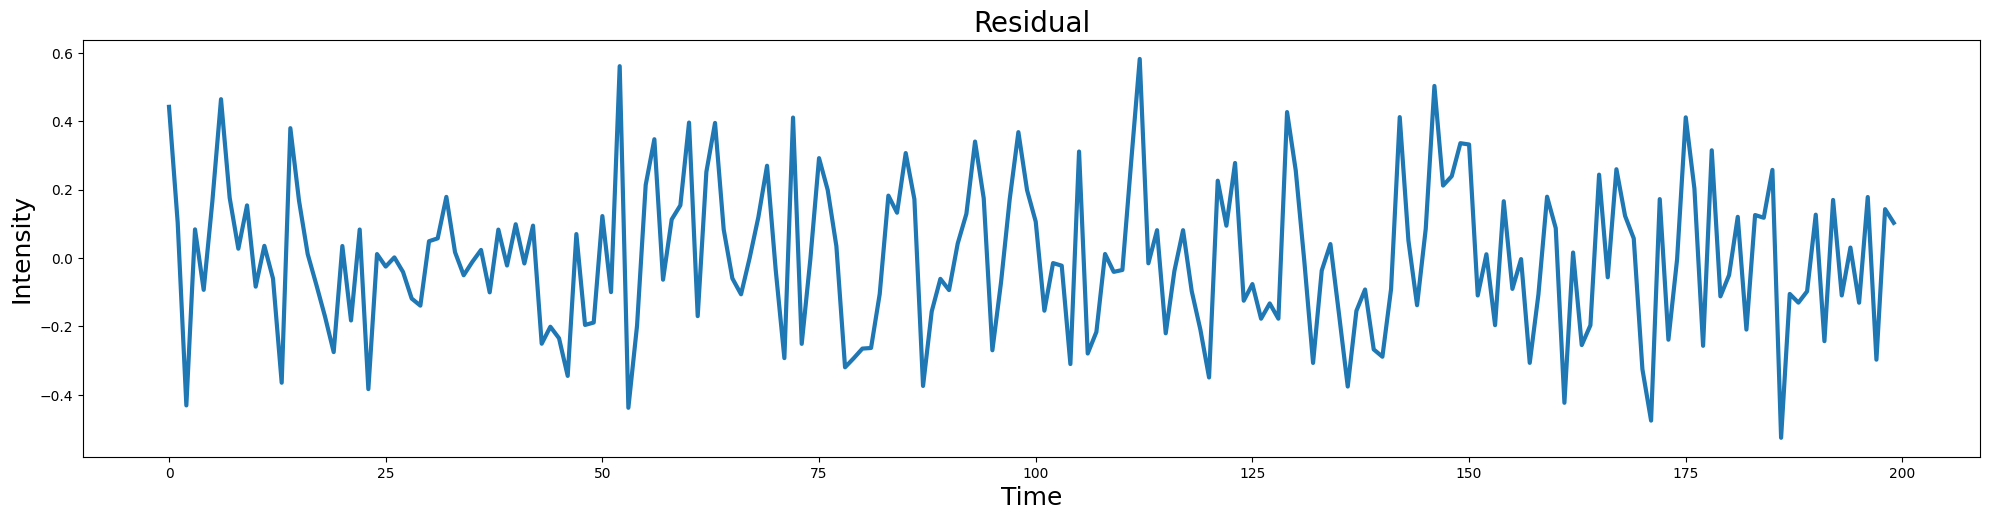

In [16]:
# 予実プロット
predicted_y = np.dot(X, beta)

predicted_ts = np.vstack([Y, predicted_y]).T

plot_timeseries(predicted_ts, labels=['Simulated Voxel', 'Predicted Voxel'])

residual = Y - predicted_y

plot_timeseries(residual)
plt.title('Residual', fontsize=20)

Standard Error of the Estimate: 0.22


Text(0.5, 0, 'Prediction Error')

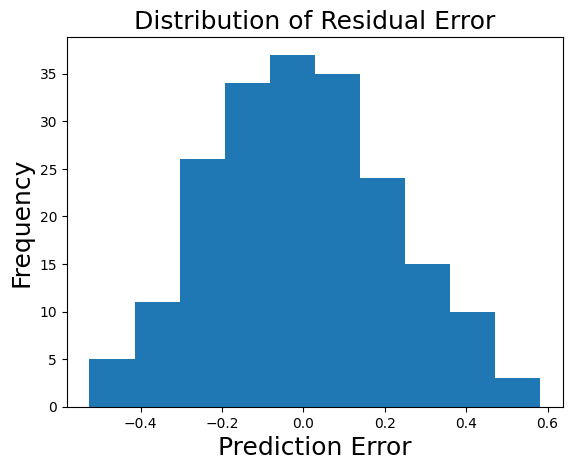

In [17]:
# 残差の分析
standard_error_of_estimate = np.std(residual)

print(f"Standard Error of the Estimate: {standard_error_of_estimate:.2}")

plt.hist(residual)
plt.title('Distribution of Residual Error', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Prediction Error', fontsize=18)

R^2: 0.58


Text(0, 0.5, 'Beta Value')

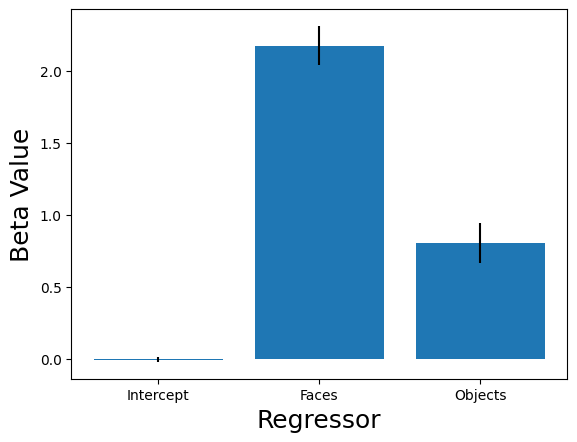

In [18]:
# 決定係数
def r_square(Y, predicted_y):
    SS_total = np.sum((Y - np.mean(Y))**2)
    SS_residual = np.sum((Y - predicted_y)**2)
    return 1-(SS_residual/SS_total)

print(f"R^2: {r_square(Y, predicted_y):.2}")

# 推定値プロットにエラーバーをつける（95％信頼区間）
std_error = np.sqrt(np.diag((np.linalg.pinv(np.dot(X.T, X))))) * standard_error_of_estimate

plt.bar(['Intercept','Faces', 'Objects'], beta, yerr = std_error)
plt.xlabel('Regressor', fontsize=18)
plt.ylabel('Beta Value', fontsize=18)

In [19]:
t = beta/std_error
t

array([-0.23842222, 15.83985108,  5.87884009])

[8.11798968e-01 4.24456301e-37 1.71912009e-08]


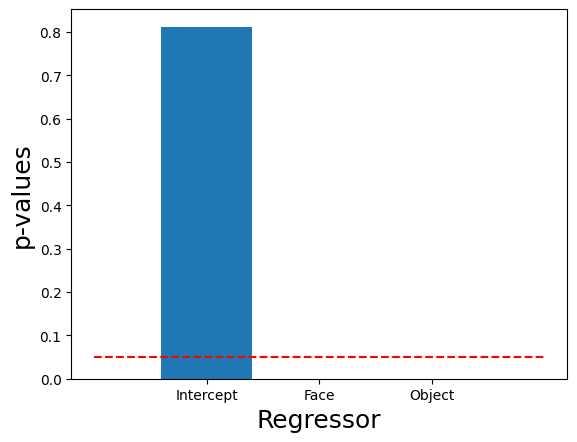

In [20]:
# 回帰係数の有意性検定
from scipy import stats

p = stats.t.sf(np.abs(t), n_tr-1)*2
print(p)

plt.bar(['Intercept', 'Face', 'Object'], p)
plt.ylabel('p-values', fontsize=18)
plt.xlabel('Regressor', fontsize=18)
plt.hlines(0.05, -1, 3, linestyles='dashed', color='red')

# コントラスト

続きやって